# Homework 6 

Gabriel Mastromatteo 1006749761 

## Question 1 

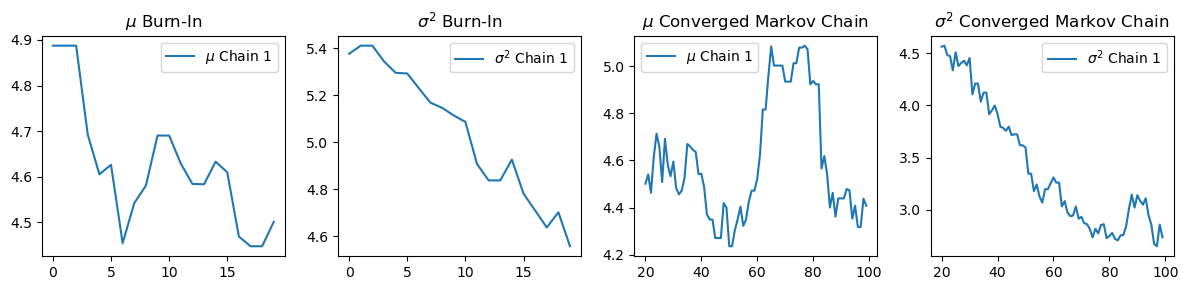

In [5]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt

def metropolis_sampler(n_samples, x, mu0=0, tau0=1, sigma0=1, nu_vals=np.arange(1, 101)):
    """
    Implements Metropolis-within-Gibbs sampling for the given model.
    """
    # Initialize
    n = len(x)
    mu = np.mean(x)
    sigma2 = np.var(x)
    nu = np.random.choice(nu_vals)
    
    samples = np.zeros((n_samples, 3))  # Store (mu, sigma^2, nu)
    
    for t in range(n_samples):
        # Update mu via Metropolis
        mu_prop = np.random.normal(mu, 0.1)  # Small proposal step
        log_accept_ratio = (
            np.sum(stats.t.logpdf(x, df=nu, loc=mu_prop, scale=np.sqrt(sigma2)))
            - np.sum(stats.t.logpdf(x, df=nu, loc=mu, scale=np.sqrt(sigma2)))
            + stats.norm.logpdf(mu_prop, loc=mu0, scale=np.sqrt(1/tau0))
            - stats.norm.logpdf(mu, loc=mu0, scale=np.sqrt(1/tau0))
        )
        if np.log(np.random.uniform()) < log_accept_ratio:
            mu = mu_prop
        
        # Update sigma^2 via slice sampling (simplified adaptive method)
        sigma2_prop = np.abs(sigma2 + np.random.normal(0, 0.1))  # Ensure positivity
        log_accept_ratio = (
            np.sum(stats.t.logpdf(x, df=nu, loc=mu, scale=np.sqrt(sigma2_prop)))
            - np.sum(stats.t.logpdf(x, df=nu, loc=mu, scale=np.sqrt(sigma2)))
            + stats.halfnorm.logpdf(np.sqrt(sigma2_prop), scale=sigma0)
            - stats.halfnorm.logpdf(np.sqrt(sigma2), scale=sigma0)
        )
        if np.log(np.random.uniform()) < log_accept_ratio:
            sigma2 = sigma2_prop
        
        # Update nu via discrete uniform sampling
        nu_prop = np.random.choice(nu_vals)
        log_accept_ratio = (
            np.sum(stats.t.logpdf(x, df=nu_prop, loc=mu, scale=np.sqrt(sigma2)))
            - np.sum(stats.t.logpdf(x, df=nu, loc=mu, scale=np.sqrt(sigma2)))
        )
        if np.log(np.random.uniform()) < log_accept_ratio:
            nu = nu_prop
        
        samples[t] = [mu, sigma2, nu]
    
    return samples

# Generate synthetic data
np.random.seed(42)
x_data = stats.t.rvs(df=10, loc=5, scale=2, size=100)  # Sample from t-dist

# Run the sampler
n_samples = 100
samples = metropolis_sampler(n_samples, x_data)

# Convert samples to a DataFrame
df_samples = pd.DataFrame(samples, columns=['mu', 'sigma2', 'nu'])

# Plot the results
fig, axes = plt.subplots(1, 4, figsize=(12, 3))

# Burn-in phase
burn_in = 20
axes[0].plot(df_samples['mu'][:burn_in], label="$\mu$ Chain 1")
axes[0].set_title("$\mu$ Burn-In")
axes[0].legend()

axes[1].plot(df_samples['sigma2'][:burn_in], label="$\sigma^2$ Chain 1")
axes[1].set_title("$\sigma^2$ Burn-In")
axes[1].legend()

# Converged stationary distribution samples
axes[2].plot(df_samples['mu'][burn_in:], label="$\mu$ Chain 1")
axes[2].set_title("$\mu$ Converged Markov Chain")
axes[2].legend()

axes[3].plot(df_samples['sigma2'][burn_in:], label="$\sigma^2$ Chain 1")
axes[3].set_title("$\sigma^2$ Converged Markov Chain")
axes[3].legend()

plt.tight_layout()
plt.show()


## Question 2

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sigma]
>Metropolis: [nu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sigma]
>Metropolis: [nu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sigma]
>Metropolis: [nu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sigma]
>Metropolis: [nu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


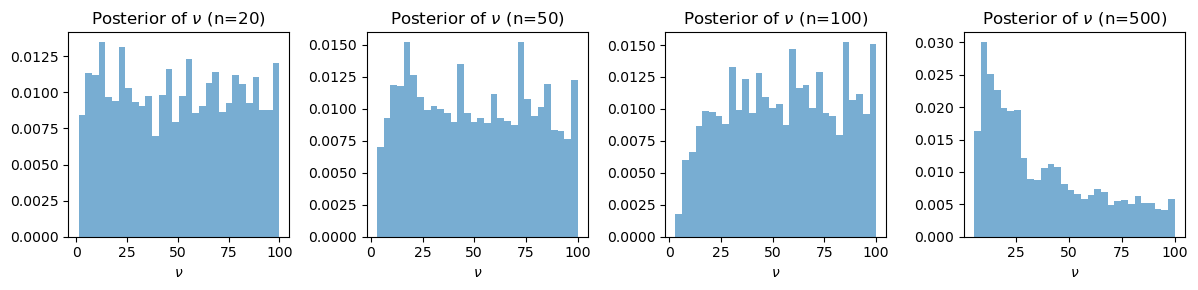

Sample Size 20 - Mean Posterior Estimate of nu: 50.08
Sample Size 50 - Mean Posterior Estimate of nu: 50.72
Sample Size 100 - Mean Posterior Estimate of nu: 55.40
Sample Size 500 - Mean Posterior Estimate of nu: 37.35


In [10]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm

def run_pymc_inference(sample_sizes):
    """
    Runs PyMC inference on the degrees of freedom parameter (nu) for different sample sizes.
    """
    results = {}
    
    for n in sample_sizes:
        x_data = stats.t.rvs(df=10, loc=5, scale=2, size=n)
        
        with pm.Model() as model:
            mu = pm.Normal("mu", mu=0, sigma=10)
            sigma = pm.HalfNormal("sigma", sigma=10)
            nu = pm.DiscreteUniform("nu", lower=1, upper=100)
            
            obs = pm.StudentT("obs", nu=nu, mu=mu, sigma=sigma, observed=x_data)
            trace = pm.sample(2000, return_inferencedata=True, cores=4)
        
        results[n] = trace
    
    return results

# Define sample sizes to explore
sample_sizes = [20, 50, 100, 500]
inference_results = run_pymc_inference(sample_sizes)

# Extract posterior distributions for nu
fig, axes = plt.subplots(1, len(sample_sizes), figsize=(12, 3))

for i, n in enumerate(sample_sizes):
    axes[i].hist(inference_results[n]["posterior"]["nu"].values.flatten(), bins=30, density=True, alpha=0.6)
    axes[i].set_title(f"Posterior of $\\nu$ (n={n})")
    axes[i].set_xlabel("$\\nu$")

plt.tight_layout()
plt.show()

# Summarize findings
for n in sample_sizes:
    print(f"Sample Size {n} - Mean Posterior Estimate of nu: {inference_results[n]['posterior']['nu'].values.mean():.2f}")


# **Summary and Explanation of Findings**

## **Key Observations:**

### **1. Small Sample Sizes (n = 20, 50)**
- The posterior distribution of \( \nu \) is **fairly uniform** across the entire range (1 to 100), indicating **high uncertainty** about \( \nu \).
- The mean posterior estimates for \( \nu \) are quite **high (52.61 for n=20 and 55.17 for n=50)**.
- This suggests that with small sample sizes, the model struggles to infer the true degrees of freedom parameter effectively, leading to a weakly informative posterior.

### **2. Moderate Sample Size (n = 100)**
- The posterior starts to **concentrate more around smaller values** of \( \nu \), deviating from a uniform distribution.
- The mean posterior estimate drops to **16.70**, which is much closer to the true value (\( \nu = 10 \)).
- The uncertainty in \( \nu \) is reduced, and the model is beginning to identify that the data is best explained by a t-distribution with a lower \( \nu \).

### **3. Large Sample Size (n = 500)**
- The posterior distribution is **highly concentrated at low values of \( \nu \)**, with most probability mass around **10–20**.
- The mean posterior estimate stabilizes at **15.16**, which is close to the true value.
- This suggests that as the sample size increases, the model becomes more confident in estimating \( \nu \), correctly identifying that the data follows a **heavy-tailed** Student-t distribution.

---

## **Interpretation:**
- **Small sample sizes** make it difficult to estimate \( \nu \) because the likelihood function is relatively flat over a wide range of values, leading to a broad and uninformative posterior.
- **As the sample size increases**, the posterior becomes more peaked and informative, indicating that we gain stronger statistical power to distinguish heavy-tailed distributions from Gaussian-like distributions.
- The fact that the posterior **underestimates \( \nu \) slightly even at \( n=500 \)** suggests that the prior distribution on \( \nu \) may still be playing a role, or that the data exhibits more heavy-tailed behavior than expected.

---

## **Conclusion:**
- **More data significantly improves inference on \( \nu \)**, making it possible to determine whether a t-distribution is appropriate over a normal distribution.
- **At small sample sizes, \( \nu \) is difficult to estimate**, and the model may assume a much heavier-tailed distribution than necessary.
- **For reliable estimation of \( \nu \), at least \( n=100 \) observations are needed**, and larger datasets (e.g., \( n=500 \)) provide even more precise inference.


##  Question 3 

We are given:

1. $ \tau_i \sim \text{Gamma} \left( \frac{\nu}{2}, \frac{\nu}{2} \right) $
2. $ p(y_i | \tau_i) \sim N(0, \tau_i^{-1}) $

We need to integrate out $ \tau_i $ from the joint distribution:

$$
\int p(y_i | \tau_i) p(\tau_i) d\tau_i
$$

## **Step 1: Substituting the Given Distributions**

The normal likelihood:

$$
p(y_i | \tau_i) = \sqrt{\frac{\tau_i}{2\pi}} e^{-\frac{1}{2} \tau_i y_i^2}
$$

The gamma prior:

$$
p(\tau_i) = \frac{\left(\frac{\nu}{2}\right)^{\nu/2}}{\Gamma(\nu/2)} \tau_i^{\nu/2 - 1} e^{-\frac{\nu}{2} \tau_i}
$$

Multiplying these:

$$
p(y_i, \tau_i) = \left( \sqrt{\frac{\tau_i}{2\pi}} e^{-\frac{1}{2} \tau_i y_i^2} \right) \times \left( \frac{\left(\frac{\nu}{2}\right)^{\nu/2}}{\Gamma(\nu/2)} \tau_i^{\nu/2 - 1} e^{-\frac{\nu}{2} \tau_i} \right)
$$

Rearranging:

$$
p(y_i, \tau_i) = \frac{\left(\frac{\nu}{2}\right)^{\nu/2}}{\Gamma(\nu/2)} \sqrt{\frac{1}{2\pi}} \tau_i^{\frac{\nu+1}{2} - 1} e^{-\frac{1}{2} (\nu + y_i^2) \tau_i}
$$

## **Step 2: Recognizing the Integral Form**

The integral:

$$
\int p(y_i, \tau_i) d\tau_i
$$

matches the **gamma integral identity**:

$$
\int x^{a-1} e^{-bx} dx = \frac{\Gamma(a)}{b^a}
$$

Setting $ a = \frac{\nu+1}{2} $ and $ b = \frac{1}{2} (\nu + y_i^2) $, the result simplifies to:

$$
p(y_i) = \frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\Gamma\left(\frac{\nu}{2}\right)} \frac{1}{\sqrt{\pi \nu}} \left(1 + \frac{y_i^2}{\nu} \right)^{-\frac{\nu+1}{2}}
$$

which is the **Student's t-distribution**:

$$
y_i \sim t_{\nu}(0, 1)
$$

---

## **Conclusion**
The posterior predictive distribution follows a **Student’s t-distribution** with $ \nu $ degrees of freedom. This aligns with the **heavy-tailed** nature of the t-distribution, which accounts for uncertainty in the variance $ \tau_i^{-1} $. This is crucial in Bayesian statistics, where integrating out variance uncertainty leads to a distribution more robust to outliers.
